# Deep Reinforcement Learning for Autonomous Driving

## DRL-flatten-image Agent Implementation

This notebook presents a Deep Reinforcement Learning approach for self-driving cars, implementing the DRL-flatten-image agent architecture. This agent processes a segmented black and white frontal road image by resizing it from 640x480 to 11x11 pixels, then flattening the image to a 121-dimensional vector. This vector is concatenated with driving features and fed into a simple two-layer fully-connected neural network.



The DRL-flatten-image agent uses a B/W segmented image of the road captured from the vehicle's perspective. Key architectural features include:

- **Input Processing**: The agent reshapes a B/W frontal image from 640x480 pixels to 11x11 pixels, reducing data from approximately 300,000 to just 121 data points.
- **State Representation**: After resizing, the image is flattened and forms the state vector S = ([P₀, P₁, P₂, ..., P₁₂₀], t, dt), where P₀...P₁₂₀ are the pixel values, and t, dt are temporal driving features.
- **Network Architecture**: The state vector is processed by a simple yet effective neural network with 2 fully-connected layers.

This lightweight architecture significantly reduces computational demands while maintaining sufficient information for effective real-time autonomous driving control.

## 1. Import the Necessary Packages

The following cell imports all required libraries for implementing our DRL agent, including PyTorch for neural networks, Gymnasium for the environment interface, and custom modules for our agent implementation.

In [ ]:
# Add this at the top of your notebook
import sys
import os
# Add the parent directory to sys.path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '.')))

# Now your imports should work
import gymnasium as gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from src.agents.drl_flatten_agent import DRLFlattenAgent

%matplotlib inline

## 1.1 Load and Display the Input Image

In this step, we load a raw RGB image from the specified path and display it in its original format. This represents the visual input that would be captured by the autonomous vehicle's camera, which will subsequently be processed for the DRL agent.

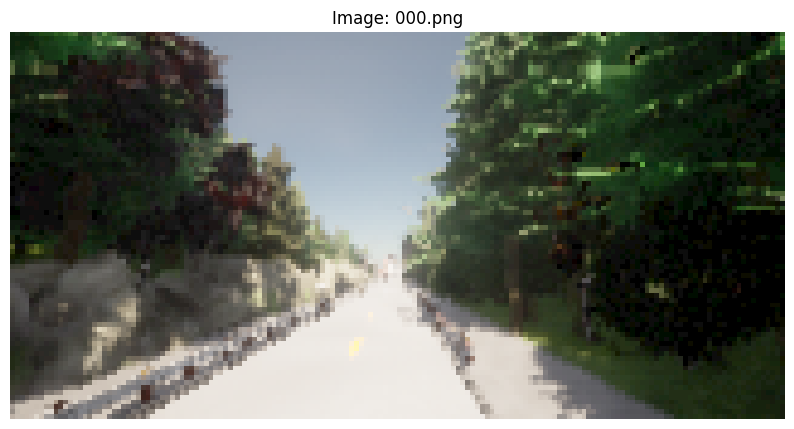

In [2]:
import cv2


image_path = os.path.abspath(os.path.join(os.getcwd(), '.', 'data', 'rgb', '000.png'))
if not os.path.exists(image_path):
    print(f"Image not found. Check the path: {image_path}")
else:
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Display the image
    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.title(f'Image: {os.path.basename(image_path)}')
    plt.show()


## 1.2 Image Preprocessing - RGB to Normalized Format

The preprocessing pipeline maintains RGB color information (3 channels) rather than converting to grayscale. This preserves important visual features that help the agent distinguish different road elements, lane markings, and environmental conditions. The images are resized from their original resolution to 84x84 pixels, balancing computational efficiency with sufficient spatial detail for autonomous driving decisions.

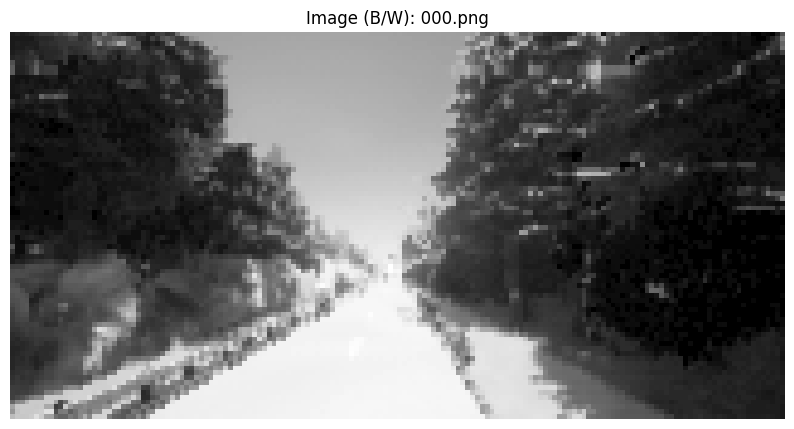

In [ ]:
# Mantener la imagen RGB (no convertir a escala de grises)
# La imagen ya está en formato RGB
image_processed = image_rgb.copy()

# Mostrar la imagen RGB original
plt.figure(figsize=(10, 8))
plt.imshow(image_processed)
plt.axis('off')  # Ocultar ejes
plt.title(f'Image (RGB Processed): {os.path.basename(image_path)}')
plt.show()

print(f"Original image shape: {image_processed.shape}")
print(f"Image will be resized to: (84, 84, 3) for the agent")

## 1.3 Resize the Image to 84x84

This preprocessing step resizes the RGB image to 84x84 pixels, reducing computational complexity while maintaining sufficient visual information for the agent. With 3 RGB channels and frame stacking of 4 consecutive frames, the final state representation has dimensions (84, 84, 12), where:
- 84x84 = spatial resolution
- 12 channels = 3 RGB channels × 4 stacked frames

This provides both spatial detail and temporal context for robust decision-making in autonomous driving.

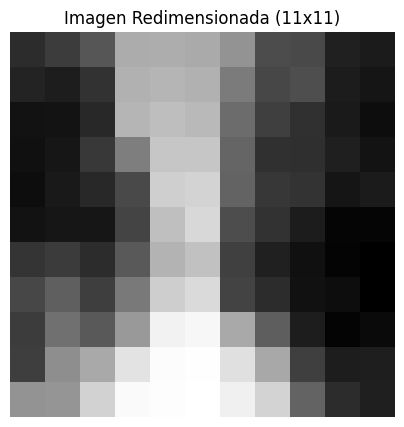

In [ ]:
# Redimensionar la imagen RGB a 84x84
image_resized = cv2.resize(image_rgb, (84, 84), interpolation=cv2.INTER_AREA)

# Mostrar la imagen redimensionada
plt.figure(figsize=(8, 8))
plt.imshow(image_resized)
plt.axis('off')  # Ocultar ejes
plt.title('Imagen Redimensionada (84x84 RGB)')
plt.show()

print(f"Resized image shape: {image_resized.shape}")
print(f"After frame stacking (4 frames), state shape will be: (84, 84, 12)")

# Normalizar la imagen (como lo hace el agente)
image_normalized = (image_resized.astype(np.float32) - 128) / 128
print(f"Normalized value range: [{image_normalized.min():.2f}, {image_normalized.max():.2f}]")

## 2. Environment and Agent Initialization

In this section, we create and configure the environment for the autonomous driving scenario. The environment provides the interface between our agent and the CARLA simulator, handling state observations, actions, and rewards.

In [5]:
# 1. Set up the configuration
from src.env.base_env import BASE_EXPERIMENT_CONFIG

config = {
    "carla": {
        "host": "localhost",
        "port": 3000,  # Use the port where CARLA is already running
        "timeout": 60.0,  # Increased timeout for slow connections
        "timestep": 0.1,
        "retries_on_error": 10,  # Increased retries
        "resolution_x": 84,
        "resolution_y": 84,
        "quality_level": "Epic",
        "use_external_server": True  # Use the existing CARLA server
    },
    "others": {
        "framestack": 4,
        "max_time_idle": 100,
        "max_time_episode": 500,
    }
}
    
# 2. Extend the base experiment config with custom settings
experiment_config = BASE_EXPERIMENT_CONFIG.copy()
experiment_config["hero"]["sensors"] = {
    "rgb_camera": {
        "type": "sensor.camera.rgb",
        "transform": "0.0,0.0,100.0,0.0,-90.0,0.0",  # x,y,z,roll,pitch,yaw (bird's eye view)
        "image_size_x": "84",  # CARLA uses image_size_x, not width
        "image_size_y": "84",  # CARLA uses image_size_y, not height
        "fov": "100",
        "size": 84  # Image size for observation space (not sent to CARLA)
    }
}
# Use default spawn points instead of a specific one
experiment_config["hero"]["spawn_points"] = []  # Empty list will use map spawn points
experiment_config["town"] = "Town05_Opt"
experiment_config["weather"] = "ClearNoon"
experiment_config["others"] = config["others"]

In [6]:
# 3. Create the experiment and environment
from src.env.base_env import BaseEnv
from src.env.carla_env import CarlaEnv


experiment = BaseEnv(experiment_config)
env = CarlaEnv(experiment, config)

In [7]:
#env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)


State shape:  (11, 11, 12)
Number of actions:  29


In [ ]:
agent = DRLFlattenAgent(env, seed=0)
state, _ = env.reset()
for j in range(10):
    action = agent.act(state)
    # env.render()
    state, reward, done, _, _ = env.step(action)
    if done:
        break
env.close()

Calculated state_size: 1452


## 3. Agent Training with Deep Q-Network

This section implements the training loop for our DRL-flatten-image agent using the Deep Q-Network algorithm. The agent will learn to map states (processed images ) to optimal actions through an epsilon-greedy exploration strategy and experience replay.

In [34]:
# Train the Agent with DQN
def dqn(n_episodes=10, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _,_ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps)   # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end='')
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))

        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

In [35]:
scores = dqn()

Episode 10	Average Score: 0.38

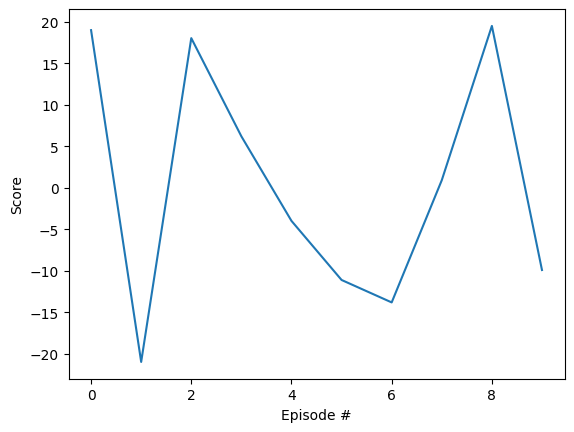

In [36]:


# Plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 4. Evaluating the Trained Agent

After training, we load the saved model weights and evaluate the agent's performance in the environment. This demonstrates the effectiveness of the trained policy in autonomous navigation tasks.

In [37]:
# Load the weights from file to watch a smart agent
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    state, _ = env.reset()
    for j in range(10):
        action = agent.act(state)
        #env.render()
        state, reward, done, _, _ = env.step(action)
        if done:
            break
env.close()

